In [1]:
#path = 'saved_model_1001_1' #epoch 60 / 20  large image x3
#path = 'saved_model_1001_softmax_RMSprop_80_30' Not bad, little noisy.
#path = 'saved_model_1001_softmax_RMSprop_100_30_0.0001' #less noisy but stamp not really good
#path = 'saved_models/saved_model_1001_softmax_RMSprop_100_40_0.0005' #less noisy. stamp better.
#path = 'saved_model_1001_softmax_Adam_100_40_0.0005' #little bit worse
#path = 'saved_model_1005_softmax_RMSprop_100_40_0.0005_with_classweights'
#path = 'saved_model_1005_softmax_RMSprop_100_30_0.0005_B8_with_classweights'
#path = 'saved_model_1005_softmax_RMSprop_50_30_0.0005_B16_with_classweights_100'
#path = 'saved_model_1005_RMSprop_100_0.0005_B1_classweights_P5_S10'
#path = 'saved_model_1005_RMSprop_80_0.0005_BNone_classweights_P5_S30'
#path = 'saved_model_1006_Adam_70_0.0005_BNone_classweights_P5_S50'
#path = 'saved_model_1006_RMSprop_70_0.0005_BNone_classweights_P86_S3055'
#path = 'saved_model_1006_RMSprop_130_0.0005_BNone_classweights_P86_S3059'
#path = 'saved_model_1006_RMSprop_150_0.0005_BNone_classweights_P86_S3056_EncoderTrained'
path = 'saved_model_1006_RMSprop_100_0.0005_BNone_classweights_P86_S3056_EncoderTrained'

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.2.0


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [4]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Ground Truth Mask', 'Pushed', 'Stamped']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    #plt.savefig("EX_1.png")
    plt.axis('off')

  plt.show()

In [5]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

  

In [6]:
mask = imread('images/test/gt_mask/일반7__분리막 눌림_검정.png') #2048 x 2448

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

color_dict = {i: list(x) for i,x in enumerate(colors)}
print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

{0: [0.0, 0.0, 0.0], 1: [0.9607843, 0.5764706, 0.19215687], 2: [0.98039216, 0.19607843, 0.3254902], 3: [0.98039216, 0.98039216, 0.21568628]}


In [7]:
model = tf.keras.models.load_model(path)

# WITHOUT TRT

In [8]:
from tqdm import tqdm
import time
import glob
import cv2

time_list = []
pred_mask = []

for idx,image in enumerate(tqdm(glob.glob("images/train/*/*.bmp"))):
    start = time.time()
    
    n = cv2.imread(image)
    n = tf.cast(n, tf.float32) / 255.0
    image = tf.image.resize(n, (480,576)) #960,1152
    
    image = tf.expand_dims(image,0)
    pred_mask.append(model(image)) # N, H, W, 3
    #print(pred_mask[0].shape)
    
    ex = pred_mask[idx][0]
    
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1))+np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    
    #display([test_y[idx],pushed,stamped])
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_count = 0
    stamp_area = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 100:
            continue
            
        stamp_area.append(area)
        stamp_count += 1
        cv2.drawContours(stamped_x, [cnt], 0, (125, 125, 0), 2)  # blue

    #display([stamped_x])
    pushed_x = pushed.astype(np.uint8) * 255

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    pushed_count = 0
    push_area = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 250:
            continue
            
        push_area.append(area)
        pushed_count += 1
        cv2.drawContours(pushed_x, [cnt], 0, (125, 125, 0), 2)  # blue

    #print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
    #                                                                                  stamp_area, push_area))
    
    #display([pushed_x])
    
    time_list.append(time.time()-start)
    
print("Average inference time is: ",np.mean(time_list) * 1000, "ms")
print(time_list)

100%|██████████| 46/46 [00:05<00:00,  7.96it/s]

Average inference time is:  125.07484270178753 ms
[1.7078697681427002, 0.09476351737976074, 0.08988046646118164, 0.08507513999938965, 0.08257818222045898, 0.08774042129516602, 0.08013701438903809, 0.09731936454772949, 0.08893656730651855, 0.09368705749511719, 0.09114861488342285, 0.09681200981140137, 0.08875608444213867, 0.0946509838104248, 0.09163689613342285, 0.09511160850524902, 0.09132814407348633, 0.09078717231750488, 0.09423422813415527, 0.09647798538208008, 0.08891987800598145, 0.09264087677001953, 0.08458328247070312, 0.08906722068786621, 0.09367823600769043, 0.09569716453552246, 0.084930419921875, 0.08913207054138184, 0.09734106063842773, 0.08432960510253906, 0.08778810501098633, 0.09163475036621094, 0.07501220703125, 0.08355069160461426, 0.09642195701599121, 0.08271145820617676, 0.08223724365234375, 0.08327794075012207, 0.10250186920166016, 0.08775210380554199, 0.0749506950378418, 0.08488750457763672, 0.09500479698181152, 0.09348940849304199, 0.0971379280090332, 0.09583306312

In [7]:
sample_image = test_x[0]
sample_mask = test_y[0]

NameError: name 'test_x' is not defined

In testing Mode...


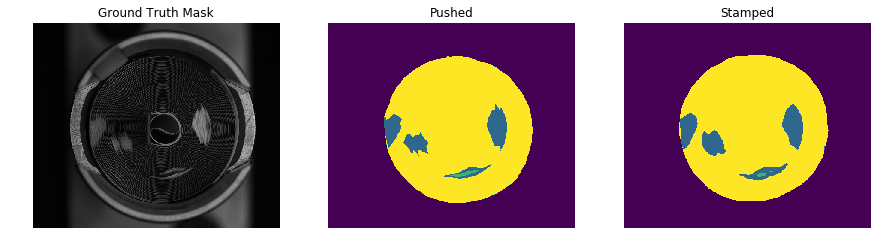

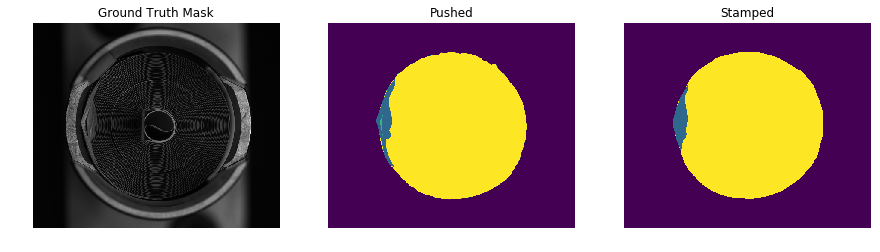

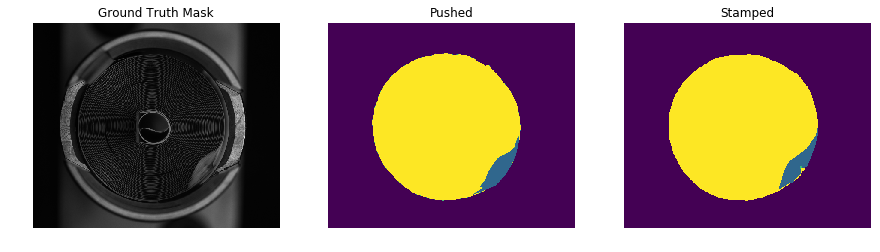

In [19]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=3)

In [8]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [9]:
# Load converted model and infer
model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [13]:
from tqdm import tqdm
import time
import glob
import cv2
time_list = []
pred_mask = []

img_loc = glob.glob("images/train/*/*.bmp")
    
    
for idx,image in enumerate(tqdm(img_loc)):
    
    start = time.time()
    
    n = cv2.imread(image)
    n = tf.cast(n, tf.float32) / 255.0
    image = tf.image.resize(n, (480,576)) #960,1152
    
    flipped = tf.image.flip_left_right(image)
    
    image = tf.expand_dims(flipped,0)
    pred_mask.append(frozen_func(image)) # N, H, W, 3
    
    ex = pred_mask[idx][0][0]
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1))+np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    
    #display([test_y[idx],pushed,stamped])
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_count = 0
    stamp_area = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 100:
            continue
            
        stamp_area.append(area)
        stamp_count += 1
        cv2.drawContours(stamped_x, [cnt], 0, (125, 125, 0), 2)  # blue

    #display([stamped_x])
    pushed_x = pushed.astype(np.uint8) * 255

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    pushed_count = 0
    push_area = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 250:
            continue
            
        push_area.append(area)
        pushed_count += 1
        cv2.drawContours(pushed_x, [cnt], 0, (125, 125, 0), 2)  # blue

    #print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
    #                                                                                  stamp_area, push_area))
    
    #display([pushed_x])
    
    time_list.append(time.time()-start)

100%|██████████| 46/46 [00:01<00:00, 26.69it/s]


In [14]:
print("Average inference time is: ",np.mean(time_list) * 1000, "ms")
print(time_list)

Average inference time is:  37.066112393918246 ms
[0.034929513931274414, 0.044884681701660156, 0.04079484939575195, 0.0415041446685791, 0.03871726989746094, 0.0369420051574707, 0.034511566162109375, 0.03470492362976074, 0.03309941291809082, 0.0407106876373291, 0.03662586212158203, 0.03461313247680664, 0.03539013862609863, 0.03377842903137207, 0.0356295108795166, 0.03603768348693848, 0.05559182167053223, 0.029886245727539062, 0.03990006446838379, 0.03483009338378906, 0.03802919387817383, 0.034293413162231445, 0.03685593605041504, 0.051831960678100586, 0.034483909606933594, 0.03867745399475098, 0.04055023193359375, 0.03506207466125488, 0.03547263145446777, 0.033124685287475586, 0.03841257095336914, 0.031174898147583008, 0.03332400321960449, 0.03363800048828125, 0.03675222396850586, 0.03110671043395996, 0.03814506530761719, 0.03581666946411133, 0.03988051414489746, 0.03291797637939453, 0.03874659538269043, 0.040505170822143555, 0.03513002395629883, 0.0363314151763916, 0.033310651779174805

In [15]:
import glob
import cv2
import gc
gc.collect()

train_x = []
train_y = []

for img in glob.glob("images/train/*/*.bmp"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, (480,576)) #960,1152

    flipped = tf.image.flip_left_right(n)

    train_x.append(flipped)

    dir = "/".join(img.split("/")[:-1]) + "/gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    y = imread(dir+file_name+".png")

    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, (480,576)) #960,1152
    flipped2 = tf.image.flip_left_right(bbb)

    train_y.append(flipped2)

test_x = tf.convert_to_tensor(train_x)
test_y = tf.convert_to_tensor(train_y)

print(test_x.shape)
print(test_y.shape)

(46, 480, 576, 3)
(46, 480, 576, 1)


Ground truth numbers:
1.   black_ng:
1, 2/1, 3, 4, 4/2, 4/2, 3/1, 1, 1, 4/1
3/3, 2, 4/1, 3/1
2.   silver_ng:
4, 4/1, 4/2, 3/1, 1, 1/1, 4/1,
3/2, 2, 4, 2/1




In [16]:
print(np.shape(pred_mask[0][0][0]))

(480, 576, 4)


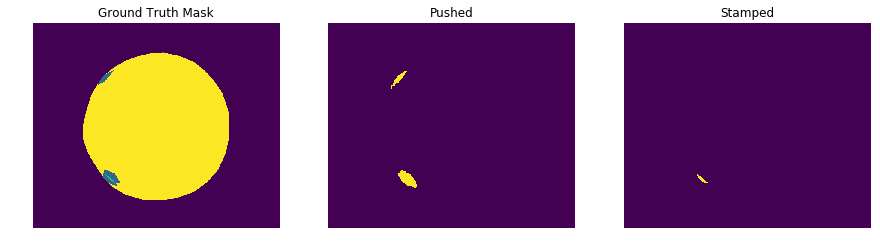

In [29]:
idx = 40

ex = pred_mask[idx][0][0]
pushed = np.round(tf.expand_dims(ex[:,:,1], -1))+np.round(tf.expand_dims(ex[:,:,2], -1))
circle = np.round(tf.expand_dims(ex[:,:,3], -1))
stamped = np.round(tf.expand_dims(ex[:,:,2], -1))

display([test_y[idx],pushed,stamped])
#cv2.imwrite("stamped.png", stamped)

#display([tf.expand_dims(ex[:,:,1], -1), tf.expand_dims(ex[:,:,3], -1), tf.expand_dims(ex[:,:,2], -1)])

Parameter setting for "Stamped"

In [67]:
stamped_x = stamped.astype(np.uint8) * 255

k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

#closed_stamp = cv2.morphologyEx(stamped_x, cv2.MORPH_CLOSE, k)

closed_stamp = cv2.dilate(stamped_x, k)

#cv2.imshow("stamp", closed_stamp)

704.5
451.5
There are 2 stamp


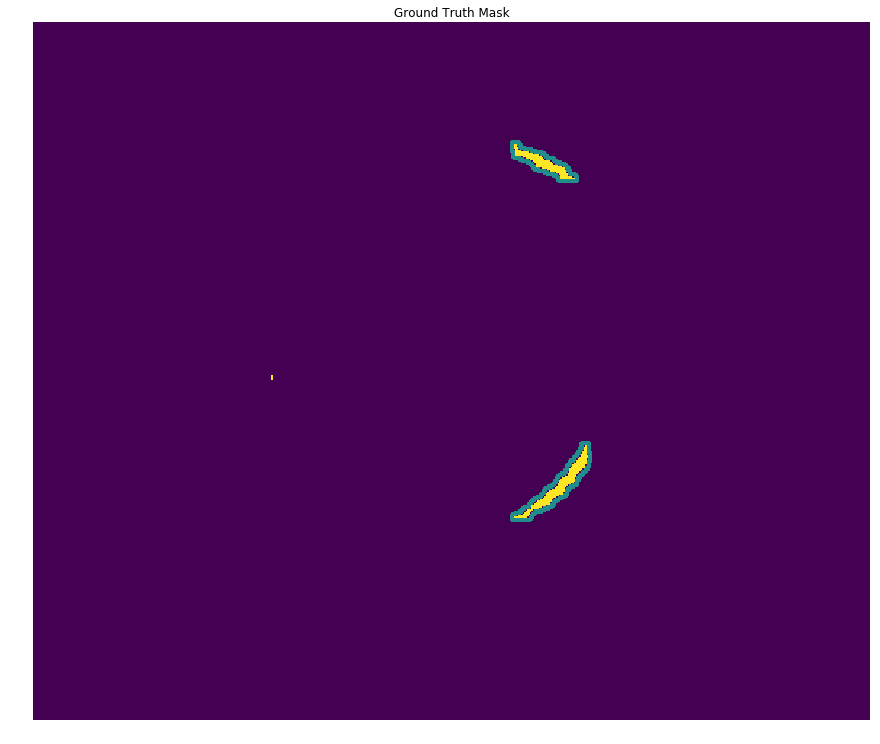

In [68]:
contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
stamp_count = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 100:
        continue
    print(area)
    stamp_count += 1
    
    cv2.drawContours(stamped_x, [cnt], 0, (125, 125, 0), 2)  # blue
    
print("There are {} stamp".format(stamp_count))
display([stamped_x])

In [69]:
pushed_x = pushed.astype(np.uint8) * 255

k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
# 닫힘 연산 적용 ---③
closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)

#cv2_imshow(closing)

1865.5
8556.0
819.0
There are 3 stamp


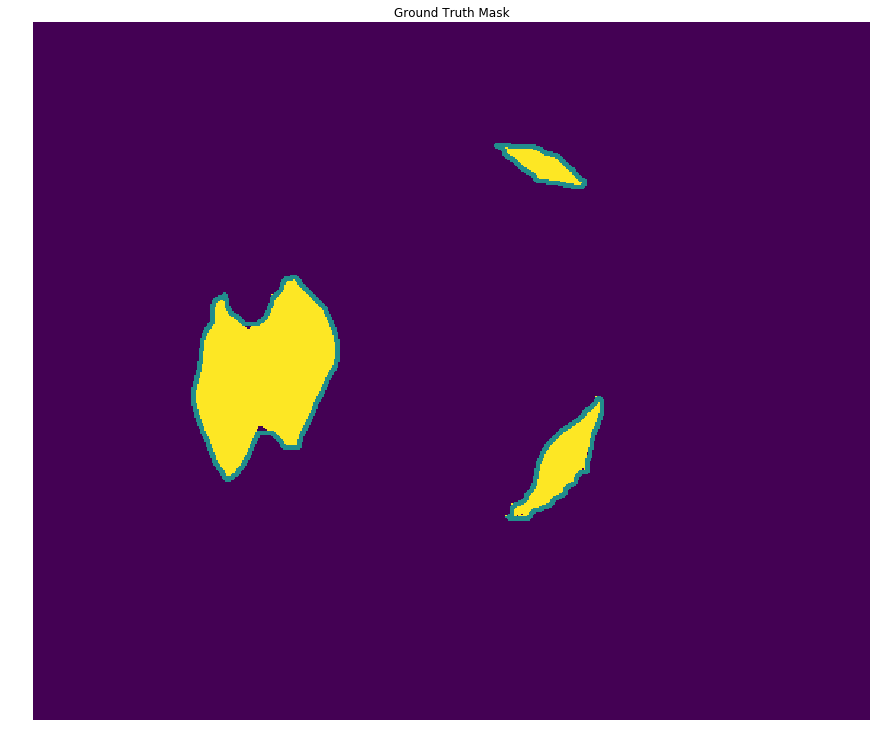

In [70]:
contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

pushed_count = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 220:
        continue
    print(area)
    pushed_count += 1
    
    cv2.drawContours(pushed_x, [cnt], 0, (125, 125, 0), 2)  # blue
    
print("There are {} stamp".format(pushed_count))
display([pushed_x])

In [18]:
import cv2
detector = cv2.SimpleBlobDetector()
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 0
params.maxThreshold = 255

#params.minRepeatability = 2

# Filter by Area.
params.filterByArea = True
params.minArea = 300 #400
params.maxArea = 1e35

# Filter by Color (black=0)
params.filterByColor = True
params.blobColor = 255

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0
params.maxCircularity = 1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0
params.maxConvexity = 1

# Filter by InertiaRatio
params.filterByInertia = True
params.minInertiaRatio = 0
params.maxInertiaRatio = 1

# Distance Between Blobs
params.minDistBetweenBlobs = 70

detector = cv2.SimpleBlobDetector_create(params)

The blob with location 356x99 has size of 25.805822372436523


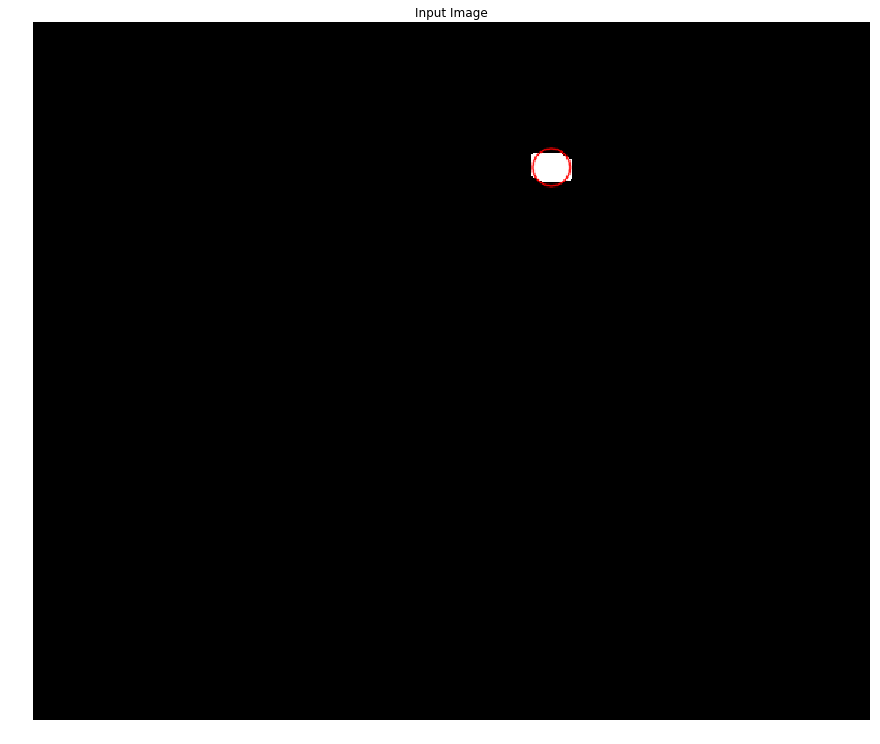

1 stamps detected


In [118]:
import math

keypoints = detector.detect(closed_stamp)
stamp_count = 0

for keypoint in keypoints:
   x = int(keypoint.pt[0])
   y = int(keypoint.pt[1])
   s = keypoint.size
   r = int(math.floor(s/2))
   print ("The blob with location {}x{} has size of {}".format(x,y,s))
   #cv2.circle(img, (x, y), r, (0, 0, 255), 2)
   stamp_count += 1

# Draw blobs
blobs = cv2.drawKeypoints(closed_stamp, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display([blobs])

print("{} stamps detected".format(stamp_count))

Parameter for "Pushed"

In [119]:
params.minArea = 170 #410
params.minDistBetweenBlobs = 50


params.minInertiaRatio = 0.013
params.maxInertiaRatio = 1 #exclude long ones

detector = cv2.SimpleBlobDetector_create(params)

In [53]:
keypoints = detector.detect(closing)
pushed_count = 0

for keypoint in keypoints:
   x = int(keypoint.pt[0])
   y = int(keypoint.pt[1])
   s = keypoint.size
   r = int(math.floor(s/2))
   print ("The blob with location {}x{} has size of {}".format(x,y,np.round(s)))
   #cv2.circle(img, (x, y), r, (0, 0, 255), 2)
   pushed_count += 1

# Draw blobs
blobs = cv2.drawKeypoints(closing, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display([blobs])

print("{} pushes detected".format(pushed_count))

NameError: name 'math' is not defined